In [1]:
#Trigger-Setting ofdmfft|source_sop either edge
import numpy as np  
import matplotlib.pyplot as plt
from signaldump import signaltapCsvDumper
import seaborn
plt.rcParams['figure.figsize']=[10,10]
import csv
import CommonScript as cs
import matplotlib.animation as animation
from bitstring import BitArray

0x90706018f0b838407070e06020407040


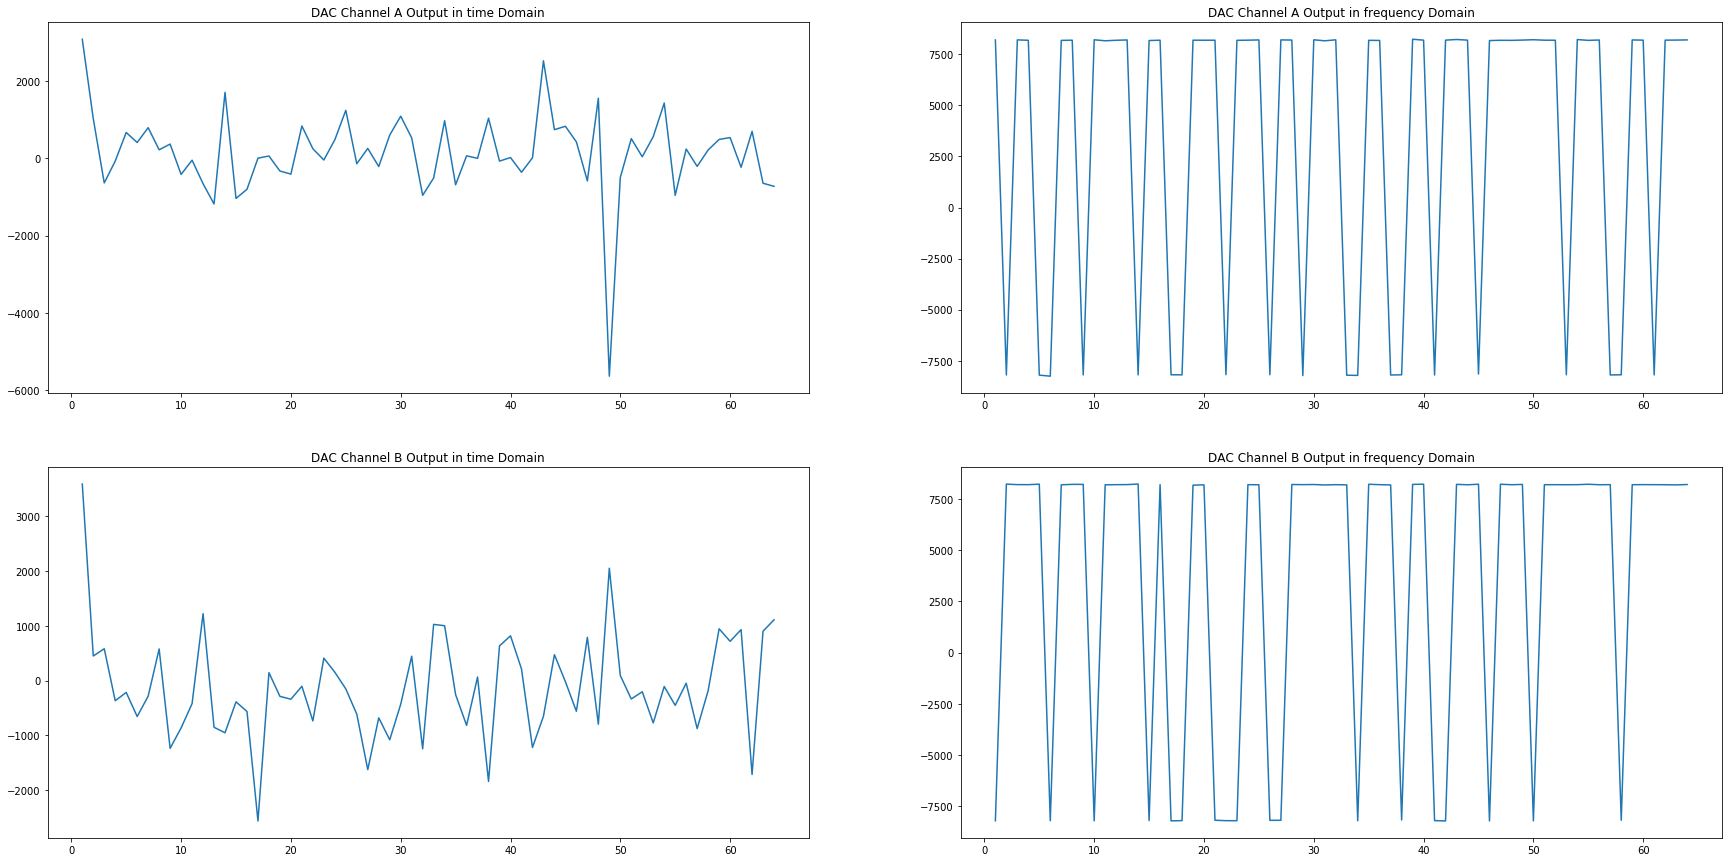

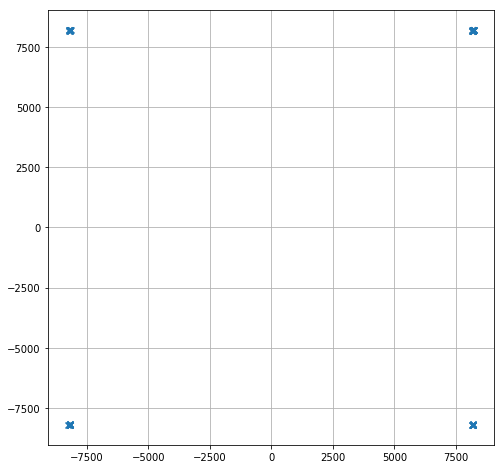

In [16]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=["DA\[(\d+)\]","DB\[(\d+)\]"],condition="active-high",validPattern=["ofdmdaccontrol|asi_in0_valid"],outputName="TransiverDAOutput",unsigned=True)
with open('./TransiverDAOutput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    real = np.array(csvBuffer[0],dtype=int)[::20]-8192
    imag = np.array(csvBuffer[1],dtype=int)[::20]-8192
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

fftResult  = frequencyDomain
demodReal=np.real(fftResult)
demodImag=np.imag(fftResult)

plt.figure(figsize=(8,8))
plt.grid(True,axis='both',which='major')
plt.scatter(demodReal,demodImag,marker='x')

demodOut = cs.ConstellationDeMapping(demodReal,demodImag)

print(hex(int(demodOut,2)))
sendData = int(demodOut,2)


0x10706018f0b838407070e06020407040
52.8


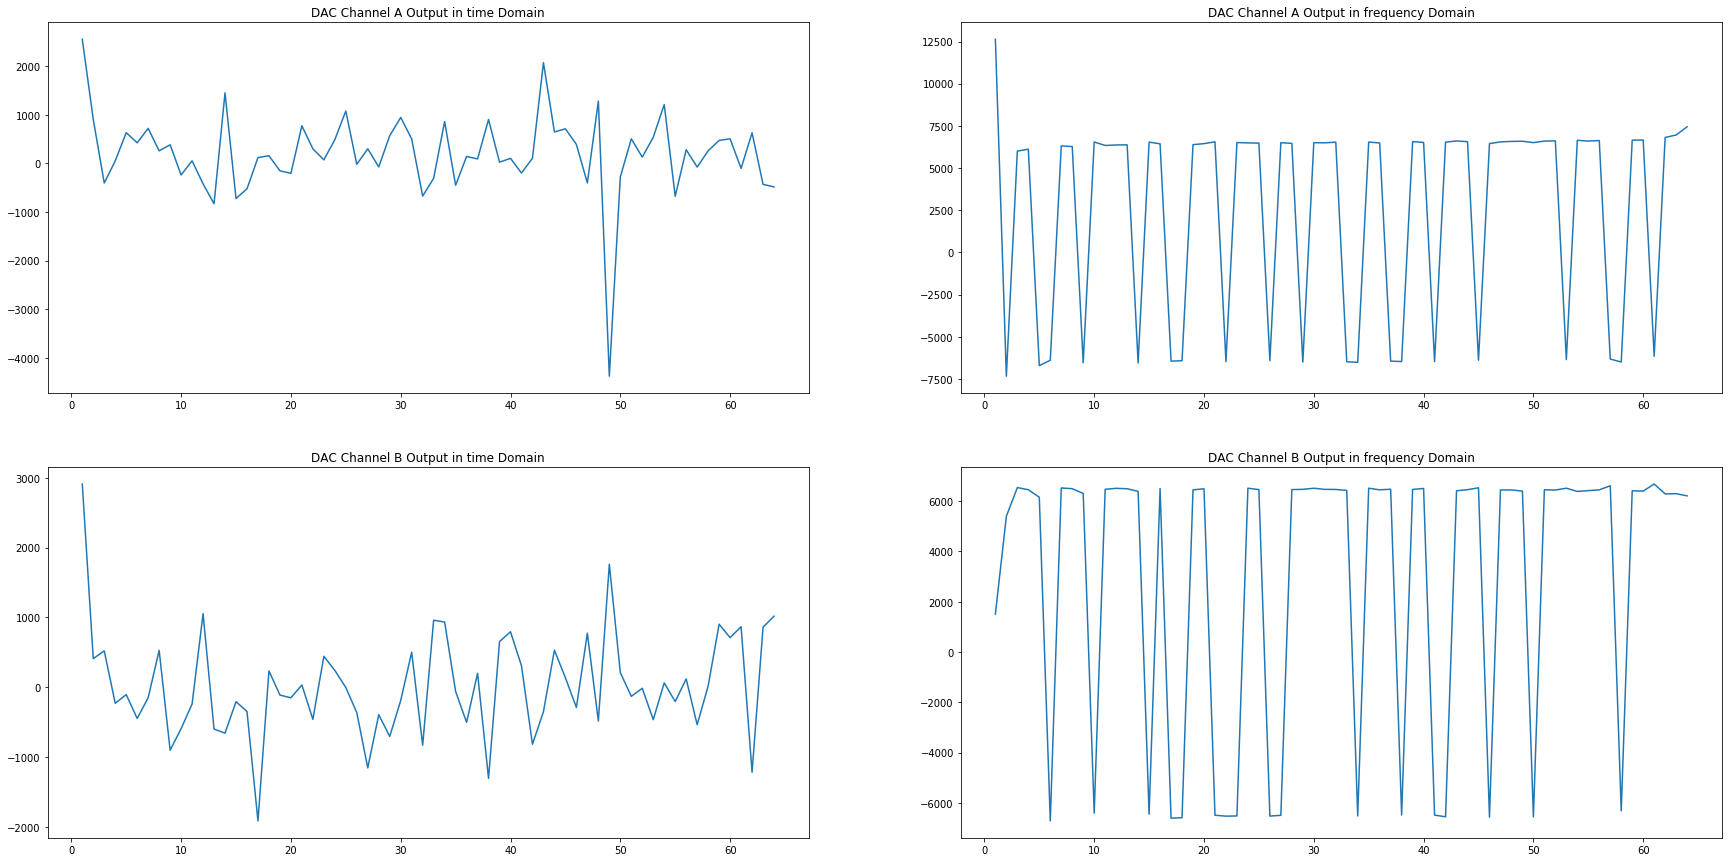

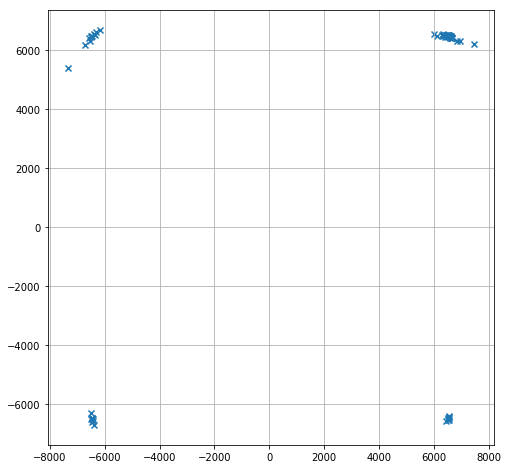

In [17]:
def symbolSync(series):
    accu_flag=0
    ma1=0
    ma2=0
    ma1_accu=0
    ma2_accu=0
    v2=0
    v1=0
    th=100
    for v,i in enumerate(real):
        ma1_accu=ma1_accu+i
        ma2_accu=ma2_accu+i
        if(v2==3):
            ma2=ma2_accu//4
#             print(ma2,ma2-ma1)
            if(accu_flag):
                if(abs(ma1-ma2)>th):
                    return v+8
            v2=0
            ma2_accu=0
        else:
            v2=v2+1
        if(v1==31):
            accu_flag=1
            ma1=ma1_accu//32
            v1=0
            ma1_accu=0
        else:
            v1=v1+1
   
dumper.dumpSession(signalPattern=["ADA_D\[(\d+)\]","ADB_D\[(\d+)\]"],condition="range",inf=0,sup=4000,outputName="ReceiverADInput")

with open('./ReceiverADInput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    real = np.negative(np.array(csvBuffer[0],dtype=int))
    imag = np.negative(np.array(csvBuffer[1],dtype=int))
    reagIndex=symbolSync(real)
    imagIndex=symbolSync(imag)
    real = real[reagIndex:reagIndex+1279:20]
    imag = imag[imagIndex:imagIndex+1279:20]
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)



            
        
        
    



128
[  207   908  -403    49   637   426   728   266   384  -235    51  -420
  -831  1462  -723  -525   124   161  -144  -209   777   302    71   485
  1079   -16   297   -68   572   951   504  -673  -309   865  -452   144
    94   913    25    99  -200   100  2077   650   716   393  -402  1292
 -4395  -281   508   130   543  1222  -672   284   -78   256   477   510
  -103   634  -433  -486]
[  140   413   522  -232  -105  -452  -149   529  -913  -601  -243  1045
  -598  -667  -210  -347 -1917   234  -110  -150    36  -460   442   236
    -6  -364 -1156  -389  -710  -188   507  -838   966   930   -70  -505
   194 -1311   654   801   307  -827  -360   531   137  -287   777  -486
  1772   207  -129   -25  -468    62  -207   116  -543    15   908   716
   875 -1221   864  1019]
0x90706018f0b838407070e06020407040
0.0


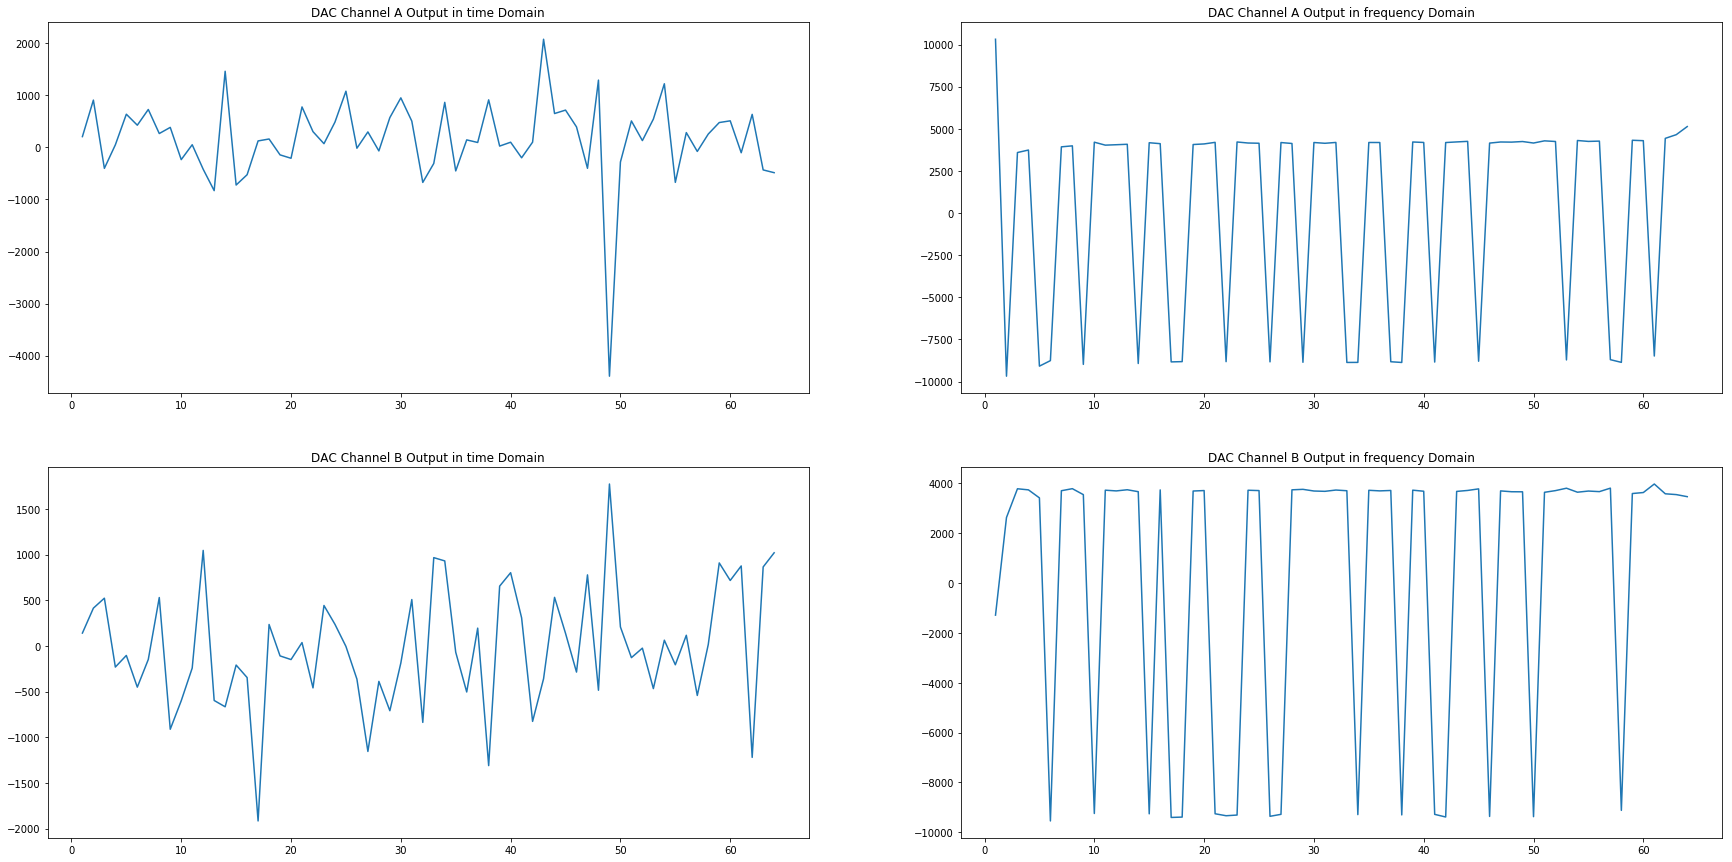

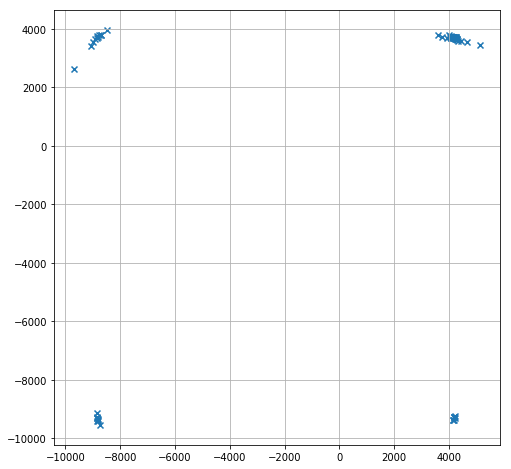

In [18]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=["ofdmsymbolsync\|aso_out0_data\[(\d+)\]"],condition="active-high",validPattern=["ofdmsymbolsync|aso_out0_valid"],outputName="ReceiverSyncOutput")
with open('./ReceiverSyncOutput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer[0],dtype=int)
    data = [np.binary_repr(i,width=32) for i in data]
    real = np.array([BitArray(bin=i[0:16]).int for i in data])
    imag = np.array([BitArray(bin=i[16:]).int for i in data])
    print(real.size)

    real = real[0::2]
    imag = imag[0::2]
    print(real)
    print(imag)
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)


[  207   908  -403    49   637   426   728   266   384  -235    51  -420
  -831  1462  -723  -525   124   161  -144  -209   777   302    71   485
  1079   -16   297   -68   572   951   504  -673  -309   865  -452   144
    94   913    25    99  -200   100  2077   650   716   393  -402  1292
 -4395  -281   508   130   543  1222  -672   284   -78   256   477   510
  -103   634  -433  -486]
[  140   413   522  -232  -105  -452  -149   529  -913  -601  -243  1045
  -598  -667  -210  -347 -1917   234  -110  -150    36  -460   442   236
    -6  -364 -1156  -389  -710  -188   507  -838   966   930   -70  -505
   194 -1311   654   801   307  -827  -360   531   137  -287   777  -486
  1772   207  -129   -25  -468    62  -207   116  -543    15   908   716
   875 -1221   864  1019]
0x90706018f0b838407070e06020407040
0.0


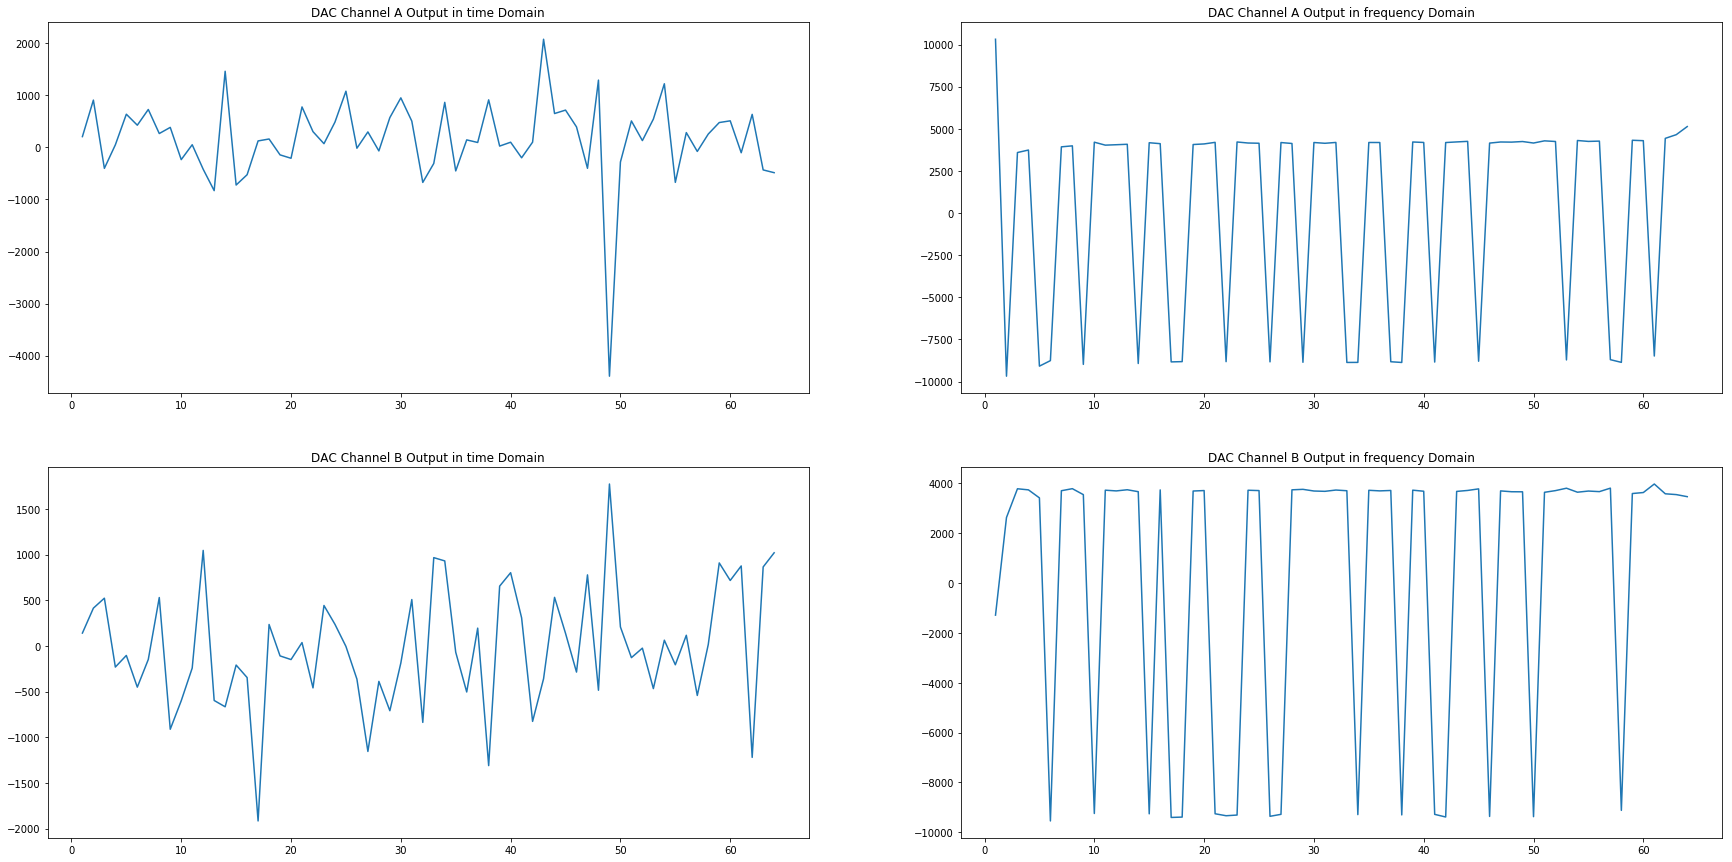

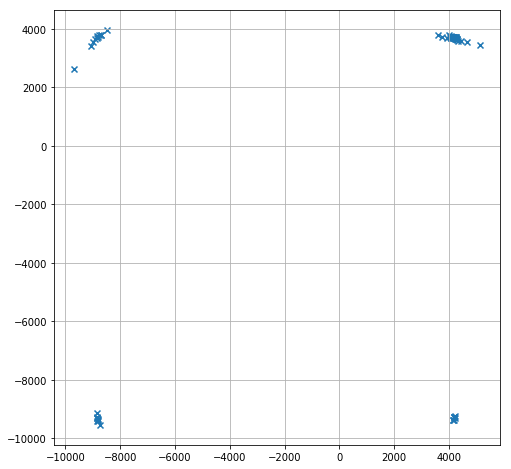

In [19]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=[".*ReceiverTopQsys_0_FFT:fft\|sink_real\[(\d+)\]",".*ReceiverTopQsys_0_FFT:fft\|sink_imag\[(\d+)\]"],condition="active-high",validPattern=["ReceiverTopQsys_0_FFT:fft|sink_valid"],outputName="RXFFTInput")
with open('./RXFFTInput.csv','r') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer,dtype=int)
    real=data[0][::2]
    imag=data[1][::2]

    print(real)
    print(imag)
    outSignal = real + imag*1j
    frequencyDomain=np.fft.fft(outSignal)
    lengthVector=np.linspace(1,64,64)
    plt.figure(figsize=(30,15))
    plt.subplot(221)
    plt.plot(lengthVector,real,'-')
    plt.title('DAC Channel A Output in time Domain')
    plt.subplot(222)
    plt.title('DAC Channel A Output in frequency Domain')
    plt.plot(lengthVector,np.real(frequencyDomain),'-')
    plt.subplot(223)
    plt.plot(lengthVector,imag,'-')
    plt.title('DAC Channel B Output in time Domain')
    plt.subplot(224)
    plt.plot(lengthVector,np.imag(frequencyDomain),'-')

    plt.title('DAC Channel B Output in frequency Domain')

    fftResult  = frequencyDomain
    demodReal=np.real(fftResult)
    demodImag=np.imag(fftResult)

    plt.figure(figsize=(8,8))
    plt.grid(True,axis='both',which='major')
    plt.scatter(demodReal[1:],demodImag[1:],marker='x')

    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)


[ 646 -604  224  233 -567 -547  245  250 -563  264  253  253  256 -558
  261  257 -552 -551  255  256  263 -551  264  259  259 -552  261  258
 -554  263  259  262 -555 -554  263  262 -552 -554  264  262 -554  262
  264  267 -549  260  264  265  267  260  268  265 -545  270  266  267
 -544 -554  271  268 -531  278  291  321]
[ -81  165  235  234  213 -598  232  236  222 -577  234  231  234  231
 -578  234 -589 -588  231  231 -579 -584 -583  232  231 -585 -582  234
  236  231  229  234  232 -582  232  231  234 -581  232  230 -581 -587
  230  231  236 -586  230  230  228 -586  228  232  238  227  230  228
  238 -569  225  227  249  224  223  217]
0x90706018f0b838407070e06020407040
0x90706018f0b838407070e06020407040
0.0


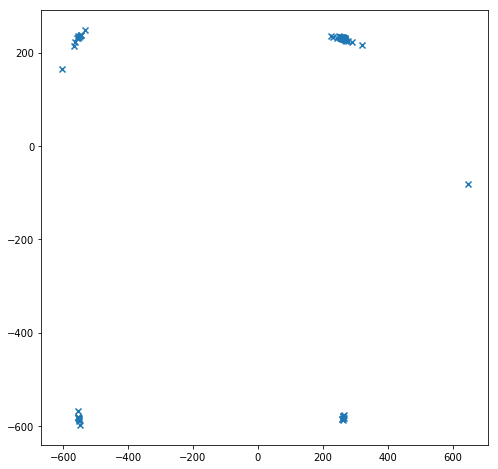

In [20]:
dumper=signaltapCsvDumper('../stp1.csv')
dumper.dumpSession(signalPattern=[".*ReceiverTopQsys_0_FFT:fft\|source_real\[(\d+)\]",".*ReceiverTopQsys_0_FFT:fft\|source_imag\[(\d+)\]"],condition="active-high",validPattern=["ReceiverTopQsys_0_FFT:fft|source_valid"],outputName="RXFFTOutput")
with open('./RXFFTOutput.csv') as fp:
    csvBuffer=list(csv.reader(fp))
    data = np.array(csvBuffer,dtype=int)
    real=data[0][::2]
    imag=data[1][::2]
    plt.figure(figsize=(8,8))
    plt.scatter(real,imag,marker='x')
    print(real)
    print(imag)


    demodOut = cs.ConstellationDeMapping(demodReal,demodImag)
    #Calculate BER
    print(hex(int(demodOut,2)))
    receiveData=int(demodOut,2)
    sendLiteral=np.binary_repr(sendData)
    receiveLiteral =np.binary_repr(receiveData)
  

    BER=100.0*len([(i,j) for i,j in zip(sendLiteral[8:],receiveLiteral[8:]) if i!=j])/len(receiveLiteral)

    print(hex(int(demodOut,2)))
    print(BER)
